# Second Homework: Network Optimization and Non-linear Models

Lucía Cordero Sánchez  
100451178

## Part 1: Network Optimization

### <span style="color: #6698FF;">1.1. The $p$-Median Problem</span>

The goal of the $p$-median problem is to locating $p$ facilities to minimize the demand weighted average distance between demand nodes and the nearest of the selected facilities. Hakimi first considered this problem for the design of network switch centers. However, this problem has been used to model a wide range of applications, such as warehouse location, depot location, school districting and sensor placement.

## <span style="color: #6698FF;">Problem Statement</span> 


In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory  

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

In our networks problem, we have the same botanical business we had in HW1. In this case, the owner wants to place at most **5 new depots** to supply all the demand of the country, which is currently providing their services to 40 neighbors' communities.

In this discrete model, we wish to place 5 facilities to **minimize the (demand-weighted) average distance between a demand node and the location in which a facility was placed**. This serves as an approximation to total delivery cost. 

In [2]:
#Nodes
N = 40

#Coordinates
np.random.seed(1)
X = list(np.random.random(N)*100)
Y = list(np.random.random(N)*100)


#Generating the demand
demanda = list(np.random.randint(low = 10, high = 50, size = N))

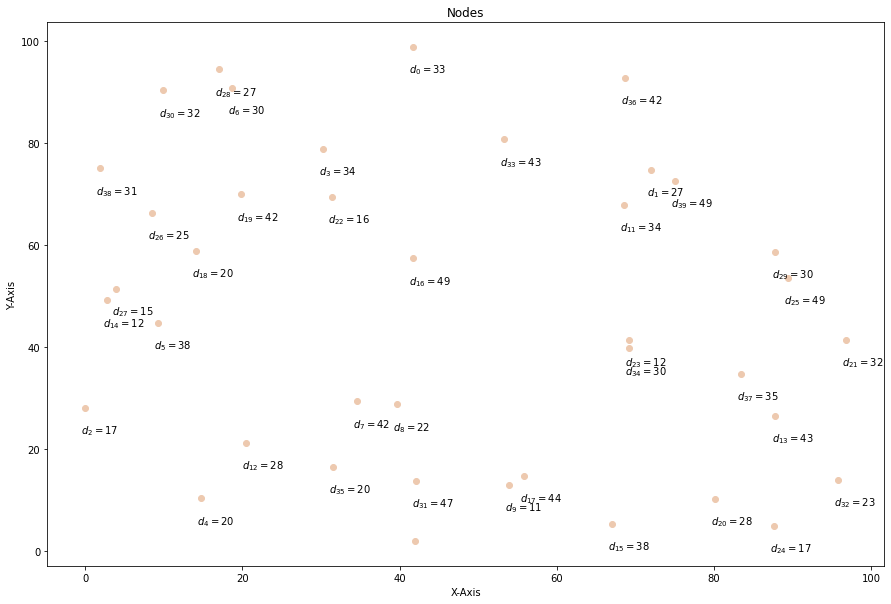

In [3]:
#Plot the nodes

plt.figure(figsize= (15,10))
plt.scatter(X,Y, color = "#EDC9AF")

for i in range(len(X)):
    plt.annotate('$d_{%d}=%d$' %(i, demanda[i]), (X[i]-0.5, Y[i]-5))
    
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("Nodes")
plt.show()

### <span style="color: #6698FF;">Sets and parameters</span> 

- nodes:  Set of customer demand nodes which represent a client | $I = 1, 2, ..., 40$

- vertices: Set of candidate locations | $J = 1, 2, ..., 40$

- edges: All arcs between each node and location | $A = {(i,j)\in IxJ}$
- $p =$ number of facilities to install
- $d_j$ = demand at location $j$

In [4]:
#Create the model
model = ConcreteModel()

#sets, conjuntos
nodes = [i for i in range(N)]
model.nodes = Set(initialize=nodes)
model.ubicaciones = Set(initialize=nodes)

edges = [(i,j) for i in model.nodes for j in model.ubicaciones]
model.edges = Set(within=model.nodes*model.nodes, initialize=edges)

#number of facilities 
model.p = 5

#distance matrix 
distance = {(i,j): np.hypot(X[i]-X[j], Y[i]-Y[j]) for i in model.nodes for j in model.ubicaciones}
model.distance = Param(model.edges, initialize=distance) 

### <span style="color: #6698FF;">Decision variables</span> 

$$
x_{ij} =
\left\{\begin{array}{ll} 
1, & \text{ if the demand of customer $j$ is supplied by facility $i$,   $\forall i \in I, \forall j \in J$}\\
0, & \text{else}
\end{array} \right.\quad 
$$

$$
y_{i} =
\left\{\begin{array}{ll} 
1, & \text{ if a facility is located at location $i$, $\forall i \in I$}\\
0, & \text{else}
\end{array} \right.\quad 
$$

In [5]:
#variables de decisión
model.x = Var(model.edges, domain=Reals, bounds=(0, 1)) 
model.y = Var(model.ubicaciones, domain=Reals, bounds=(0, 1)) #a binary value that is 1 is a facility is located at location i

### <span style="color: #6698FF;">Objective function</span> 

$\min Z = \min \sum_{i \in I} \sum_{j \in J} d_j x_{ij}$


In [6]:
def objective_function(model):
    return sum(model.distance[i, j] * model.x[i, j]
               for (i, j) in model.edges)

model.obj = Objective(sense=minimize, rule=objective_function) #minimize

### <span style="color: #6698FF;">Constraints</span> 

All of the demand for customer $j$ must be satisfied:

$\sum_{i \in I} x_{ij} = 1$, $\forall j \in J$    

Exactly $p$ facilities are located

$\sum_{i \in I} y_i = p$

Demand nodes can only be assigned to open facilities

$x_{ij} \leq y_i$, $\forall i \in I, \forall j \in J$

In [7]:
# Constraints

#first constraint: explain -> All of the demand for customer j must be satisfied
def flow_constraint(model, j):
    return sum(model.x[i,j] for i in model.nodes) == 1

model.flow_constraint = Constraint(model.nodes, rule=flow_constraint)

# Exactly p facilities are located 
def facilities_constraint(model):
    return sum(model.y[j] for j in model.ubicaciones) == model.p
model.facilities_constraint = Constraint(rule=facilities_constraint)

# Demand nodes can only be assigned to open facilities 
def demand_constraint(model, i, j):
    return model.x[i,j] <= model.y[i]
model.demand_constraint = Constraint(model.nodes, model.ubicaciones, rule=demand_constraint)

In [8]:
# Solving the model
solver = SolverFactory("glpk")
result = solver.solve(model)

In [2]:
#model.x.display()

In [10]:
# Active edges

active_edges = []
x_dic = model.x.get_values()
for i in x_dic.keys():
    if x_dic[i]==1:
        active_edges.append(i)


In [11]:
active_edges

[(1, 1),
 (1, 11),
 (1, 29),
 (1, 33),
 (1, 36),
 (1, 39),
 (3, 0),
 (3, 3),
 (3, 6),
 (3, 16),
 (3, 19),
 (3, 22),
 (3, 28),
 (3, 30),
 (27, 2),
 (27, 5),
 (27, 14),
 (27, 18),
 (27, 26),
 (27, 27),
 (27, 38),
 (31, 4),
 (31, 7),
 (31, 8),
 (31, 9),
 (31, 10),
 (31, 12),
 (31, 15),
 (31, 17),
 (31, 31),
 (31, 35),
 (37, 13),
 (37, 20),
 (37, 21),
 (37, 23),
 (37, 24),
 (37, 25),
 (37, 32),
 (37, 34),
 (37, 37)]

In [12]:
#Active locations

active_ubicaciones = []

y_dic = model.y.get_values()
for i in y_dic.keys():
    if y_dic[i]==1:
        active_ubicaciones.append(i)

In [13]:
active_ubicaciones

[1, 3, 27, 31, 37]

In [14]:
def Color(n):
    count = 0
    for i in matplotlib.colors.cnames.values():
        count += 1
        
        if count == n+11:
            return i

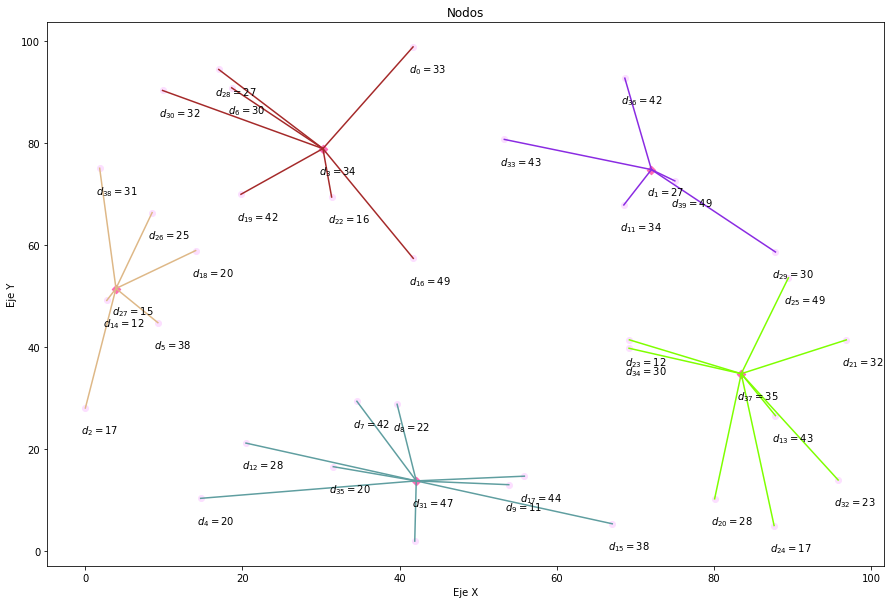

In [15]:
# Representation: This is the best possible distribution for the 5 depots that our gardening company needs

plt.figure(figsize=(15,10))
plt.scatter(X,Y, color = "#FCDFFF")

for n in active_ubicaciones:
    plt.scatter(X[n], Y[n], color = "#FF69B4", marker = "D")
    
for i in range(len(X)):
    plt.annotate('$d_{%d}=%d$' %(i, demanda[i]), (X[i]-0.5, Y[i]-5))
    

for n in active_edges:
    i = n[0] #start node for the active edge
    j = n[1] #end node for the active edge
    plt.plot([X[i],X[j]],[Y[i],Y[j]], color = Color(active_ubicaciones.index(i)))
    
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Nodos")
plt.show()

We interpret this solution better after representing it graphically: the five facilities will be placed at nodes 1, 3, 27, 31 and 37. 

With the edges, we see which of the nodes are supplied by each facility.

### <span style="color: #50C878;">1.2. The Maximal Coverage Location Problem</span>

We have a similar problem that we will solve with Gurobi.

In this case must select at most $p$ of these depots such that the maximum number of elements are covered, i.e. the union of the selected facilities has maximal size. Moreover, we know that our new facility will cover **only demands from 20km** around it.

In [1]:
%reset -f
import gurobipy as gp
from gurobipy import GRB, Model, quicksum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib


## <span style="color: #50C878;">Problem Statement</span> 

Similar mathematical formulation to the first problem follows:

### <span style="color: #50C878;">Sets and parameters</span> 

- nodos:  Set of customer demand nodes which represent a client | $I = 1, 2, ..., 40$

- vertices/ubicaciones: Set of candidate locations | $J = 1, 2, ..., 40$

- arcos: All edges between each node and location | $A = {(i,j)\in IxJ}$
- $p =$ maximum number of facilities to install
- $d_j$ = demand at location $j$

In [17]:
N=50

nodos = [i for i in range(N)]
ubicaciones = [i for i in nodos]
arcos = [(i,j) for i in nodos for j in ubicaciones]
P=5

np.random.seed(2022)

X = list(np.random.random(N)*100)
Y = list(np.random.random(N)*100)

demanda = list(np.random.randint(low=10, high=50, size = N))

distancia = {(i,j): np.hypot (X[i]-X[j], Y[i]-Y[j]) for i in nodos for j in ubicaciones}

In [18]:
max_cov = 20

$$
a_{ij} =
\left\{\begin{array}{ll} 
1, & \text{ if the demand of customer $i$ can be supplied by facility $j$,   $\forall i \in I, \forall j \in J$}\\
0, & \text{else}
\end{array} \right.\quad 
$$

In [19]:
a = { (i,j):1 if distancia[i,j] <= max_cov else 0 for i in nodos for j in ubicaciones}

### <span style="color: #50C878;">Decision variables and objective function</span> 

$$
x_{i} =
\left\{\begin{array}{ll} 
1, & \text{ when node $i \in I$ is supplied.}\\
0, & \text{else}
\end{array} \right.\quad 
$$

$$
y_{i} =
\left\{\begin{array}{ll} 
1, & \text{ when a facility is installed in the node $j \in J$.}\\
0, & \text{else}
\end{array} \right.\quad 
$$


In [20]:
model = Model('Max Cov')

#variables de decisión
x = model.addVars(nodos, vtype = GRB.BINARY, name = 'x')
y = model.addVars(ubicaciones, vtype = GRB.BINARY, name = 'y')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03


### <span style="color: #50C878;">Objective function and Constraints</span> 

$\max Z = \max \sum d_i*x_i$

such that

$\sum_{i \in I}(a_{ij}*y_i) \geq x_i,  \forall j \in J$

$\sum_{j \in J}y_i \leq p$

In [21]:
#función objetivo
model.setObjective(quicksum(demanda[i]*x[i] for i in nodos), GRB.MAXIMIZE)

model.addConstrs(quicksum(a[i,j]*y[j] for j in ubicaciones) >= x[i] for i in nodos)
model.addConstr(quicksum(y[j] for j in ubicaciones) == P)

model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51 rows, 100 columns and 366 nonzeros
Model fingerprint: 0x6f6ec71b
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+00]
Found heuristic solution: objective 904.0000000
Presolve removed 6 rows and 12 columns
Presolve time: 0.00s
Presolved: 45 rows, 88 columns, 300 nonzeros
Variable types: 0 continuous, 88 integer (83 binary)

Root relaxation: objective 1.111000e+03, 66 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0

In [22]:
arcos_activos = [k for k in nodos if x[k].x > 0.9]

In [23]:
ubicaciones_activos = [k for k in ubicaciones if y[k].x > 0.9]

In [24]:
ubicaciones_activos

[21, 29, 33, 34, 46]

In [25]:
def Color(n):
    count = 0
    for i in matplotlib.colors.cnames.values():
        count += 1
        
        if count == n+14:
            return i

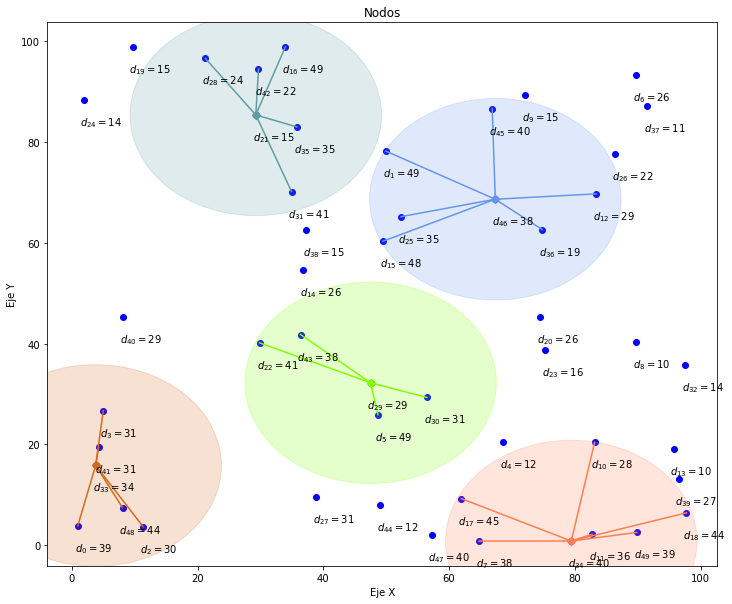

In [26]:
# Graphic representation 
plt.figure(figsize=(12,10))
plt.scatter(X,Y, color = "blue")
   
for i in range(len(X)):
    plt.annotate('$d_{%d}=%d$' %(i, demanda[i]), (X[i]-0.5, Y[i]-5))

for n in ubicaciones_activos:
    plt.scatter(X[n], Y[n], color = Color(ubicaciones_activos.index(n)), marker = "D")
    
    for k in range(len(nodos)):
        if a[(n, nodos[k])] == 1:
            i = nodos[k] 
            j = n 
            plt.plot([X[i],X[j]],[Y[i],Y[j]], color = Color(ubicaciones_activos.index(n)))

ax = plt.gca()
for c in ubicaciones_activos:
    circule = plt.Circle((X[c], Y[c]),max_cov, color = Color(ubicaciones_activos.index(c)), alpha = 0.2)
    ax.add_artist(circule)
    
plt.xlabel("Eje X")
plt.ylabel("Eje Y")
plt.title("Nodos")
plt.show()

**Interpretation:** With this plot we see that five facilities are chosen to be at locations 21, 29, 33, 34, 46. Placing their depots at these points, the company maximizes the services they can provide to each neighborhood in at most 20km around from the facility.
The demand at each point equals sum of all services (rats extermination, pool maintenance, etc.) that each neighborhood needs from the company, and they will be provided with this number of services by the professional of the company's closest facility.

## Part 2: Non-linear Models

In [4]:
%reset -f
from pyomo.environ import *
import numpy as np

### <span style="color: #FF9966;">2. 1. Biggest rectangle inside a circle</span>

### <span style="color: #FF9966;">Statement</span>
We will start with a relatively simple non-linear model: let's find the maximum area of a rectangle if we place it into a circle with radius 10cm.

![graph](graphRect.png)

In [5]:
model = ConcreteModel("Biggest rectangle in a circle")

#### <span style="color: #FF9966;">Parameters </span>
$R =$ radius of the circumference

In [6]:
model.R=Param(initialize=10)

#### <span style="color: #FF9966;">Decision variables </span>

$x =$ x-coordinate of the biggest possible rectangle, $0 \leq x \leq R$    
$y =$ y-coordinate of the biggest possible rectangle, $0 \leq y \leq R$ 

In [7]:
model.x = Var(bounds=(0,model.R), initialize=model.R)
model.y = Var(bounds=(0,model.R), initialize=model.R)

#### <span style="color: #FF9966;">Constraint </span>

$x^2 + y^2 = R^2$

In [8]:
model.c1 = Constraint(expr=model.x**2+model.y**2==model.R**2)

#### <span style="color: #FF9966;">Objective function </span>

$\max_{x,y} OF = \max_{x,y} 4xy$

In [9]:
model.f1= Objective(expr=4*model.x*model.y, sense=maximize)

In [10]:
solver=SolverFactory('ipopt') #solve with pyomo
results= solver.solve(model);

In [11]:
#optimal solutions
print("x=",round(value(model.x),3))
print("y=",round(value(model.y),3))
print("OF=",round(value(model.f1),3))

x= 7.071
y= 7.071
OF= 200.0


We see that the best possible area is 200 $cm^2$ and that our optimal rectangle's base is 14 $cm$ long.  

What will happen with this problem if we let variable x or y fixed and optimize based on this constraint?

In [12]:
#fix a model solving for x=1
model.x.fix(1)
results= solver.solve(model);

print("x=",round(value(model.x),3))
print("y=",round(value(model.y),3))
print("OF=",round(value(model.f1),3))

print("----------")
#fix for y = 1
model.x.unfix()
model.y.fix(1)
results= solver.solve(model);

print("x=",round(value(model.x),3))
print("y=",round(value(model.y),3))
print("OF=",round(value(model.f1),3))

x= 1
y= 9.95
OF= 39.799
----------
x= 9.95
y= 1
OF= 39.799


We see that if we fix one variable the results are far from optimal ones, and for both fixes the solution is symmetric.

### <span style="color: #FF9966;">2. 2. Biggest cylinder inside a sphere</span>

### <span style="color: #FF9966;">Statement</span>
For this problem, an appliances company needs to maximize the volume of a cylinder that needs to be inside a sphere of radius 1 $cm$ for a new piece they will start to supply.

<img src="graphRect2.png" alt="drawing" width="200"/>


In [13]:
model2 = ConcreteModel()

#### <span style="color: #FF9966;">Parameters </span>
$R =$ radius of the sphere

In [14]:
model2.R=Param(initialize=1)

#### <span style="color: #FF9966;">Decision variables </span>

$r =$ radius of the base of the cylinder, $0 \leq r \leq R$    
$h =$ $1/2$ height of the cylinder, $0 \leq h \leq R$ 

In [15]:
model2.h = Var(bounds=(0,model2.R), initialize=model2.R)
model2.r = Var(bounds=(0,model2.R), initialize=model2.R)

#### <span style="color: #FF9966;">Constraints </span>
The objective function is constrained to 

$x^2 + y^2 = R^2$  
$0 \leq r \leq R$  
$0 \leq h \leq R$ 

In [16]:
model2.c1 = Constraint(expr=model2.r**2+model2.h**2==model2.R**2)

#### <span style="color: #FF9966;">Objective function </span>

$\max_{r,h} OF = \max_{r,h} 2\pi r^2h$

In [17]:
model2.OF= Objective(expr=2*np.pi*(model2.r**2)*model2.h, sense=maximize)

In [18]:
#Solving the model
solver=SolverFactory('ipopt')
results= solver.solve(model2);

#Results
print("r=",round(value(model2.r),2))
print("h=",round(value(model2.h),2))
print("OF=",round(value(model2.OF),2))

print("-----------")
print("r without rounding=",value(model2.r))
print("h without rounding=",value(model2.h))
print("OF without rounding=",value(model2.OF))

r= 0.82
h= 0.58
OF= 2.42
-----------
r without rounding= 0.8164965807359517
h without rounding= 0.5773502694608884
OF without rounding= 2.4183991523125115


**Interpretation:** We see that the optimal value of the objective function (volume of the cylinder) when maximizing is approximately 2.42, and the optimal values for the radius and the height are approximately $r=0.82 cm$ and $height=2*h=1.16 cm$.

### <span style="color: #FF9966;">2.3. Circle placement in a rectangle</span>

### <span style="color: #FF9966;">Statement</span>
For this exercise, we want to allocate N circles with known radiuses (present at <span style="color: #FF9966;">radiuses.dat</span> file) in a minimum surface rectangle without overlapping each other.


In [19]:
model3 = AbstractModel()

#### <span style="color: #FF9966;">Parameters </span>

In [20]:
model3.i = Set()
model3.j = Set(initialize=model3.i) #in alias with model3.i
model3.R = Param(model3.i) #defined over set i

#### <span style="color: #FF9966;">Decision variables </span>
$x =$ x-coordinates of the center of the circles  
$y =$ y-coordinates of the center of the circles  
$W =$ width of the rectangle   
$L =$ length of the rectangle

In [21]:
def lowband(model3,i):
    return (model3.R[i],100) #100 is a big number chosen for simplicity

model3.x = Var(model3.i, bounds = lowband, within = NonNegativeReals, initialize=0)
model3.y = Var(model3.i, bounds = lowband, within = NonNegativeReals, initialize=0)
model3.W = Var(bounds = (0,100), within = NonNegativeReals, initialize=0)
model3.L = Var(bounds = (0,100), within = NonNegativeReals, initialize=0)

#### <span style="color: #FF9966;">Constraints </span>

$\forall_{i,j}$   $(x_i - x_j)^2 + (y_i-y_j)^2 \geq (r_i + r_j)^2$  to avoid overlapping between circles  
$\forall_{i}$  $r_i \leq x_i \leq W - r_i$  so the circle does not come out of them dimensions of the rectangle  
$\forall_{i}$  $ r_i \leq y_i \leq L - r_i$

In [22]:
def rule_eq1(model3, i, j):
    if i>j:
        return (model3.x[i]-model3.x[j])**2+(model3.y[i]-model3.y[j])**2 >= (model3.R[i]+model3.R[j])**2
    else:
        return Constraint.Skip;
    
model3.eq1 = Constraint(model3.i, model3.j, rule = rule_eq1)


def rule_eq2(model3, i):
    return model3.x[i] <= model3.W - model3.R[i]

model3.q2 = Constraint(model3.i, rule = rule_eq2)

def rule_eq3(model3,i):
    return model3.y[i] <= model3.L -model3.R[i]

model3.q3 =  Constraint(model3.i, rule = rule_eq3)

#### <span style="color: #FF9966;">Objective function </span>

$\min L*W$

In [23]:
def Obj_rule(model3):
    return model3.W*model3.L

model3.obj = Objective(rule=Obj_rule, sense =  minimize)
opt =  SolverFactory('ipopt')

In [24]:
instance = model3.create_instance("radiuses.dat")
results = opt.solve(instance)

WARNING (W1002): Setting Var 'x[1]' to a numeric value `0` outside the bounds
    (2, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[1]' to a numeric value `0` outside the bounds
    (2, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[2]' to a numeric value `0` outside the bounds
    (1.2, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[3]' to a numeric value `0` outside the bounds
    (1.8, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[4]' to a numeric value `0` outside the bounds
    (0.9, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'x[5]' to a numeric value `0` outside the bounds
    (3.2, 100).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Set

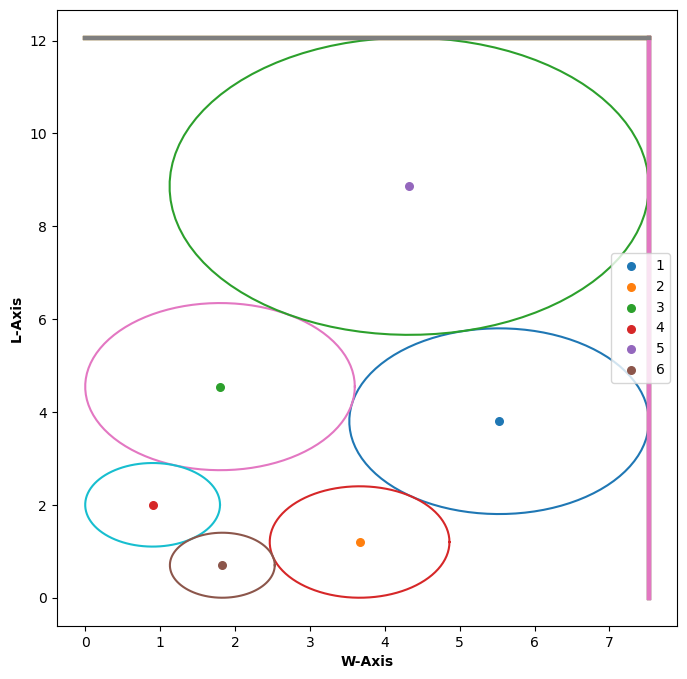

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,8))
theta =  np.linspace(0,2*np.pi,100) #theta is between 0 and 2pi, divided into 100 points
for i in instance.i:
    plt.scatter(value(instance.x[i]), value(instance.y[i]), label = str(i), s=30) #plot the dots
    Xc= value(instance.x[i]) + value(instance.R[i])*np.cos(theta) #x-center values
    Yc= value(instance.y[i]) + value(instance.R[i])*np.sin(theta) #y-center values
    plt.plot(Xc,Yc)
    plt.plot(value(instance.W)*np.ones(2), [0,value(instance.L)],lw=3)
    plt.plot([0, value(instance.W)], value(instance.L)*np.ones(2),lw=3)
    
plt.legend(loc="right")
plt.xlabel("W-Axis", fontweight="bold")
plt.ylabel("L-Axis", fontweight="bold")
plt.show()

**Interpretation of the results:** This is the optimal way to place all the circles with the given radius specified in the attached .dat file in our rectangle (minizing its area).